# Modeling And Simulating of Dynamical Systems: Biped Walker

## Rewrite everything in casadi library: Do not use nor sympy nor numpy
### Import libraries

In [3]:
import sympy as sp
import numpy as np
from sympy.physics.mechanics import *
from numpy import sin, cos, pi
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp, solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sympy import atan, symbols, Matrix, Eq, solve
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                     Particle, Point)
import sympy.physics.mechanics.system as system
from sympy.physics.vector import init_vprinting
import math
import casadi as ca
from casadi import *
from casadi.tools import *

# Bestekoak be asko redundante ba badaeszpada
# imports needed for the code (run this block)
import numpy as np
import matplotlib
from numpy import sin, cos, pi
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp
from scipy.interpolate import interp1d
from scipy.linalg import inv, solve_continuous_are, norm
from matplotlib import pyplot as plt
import matplotlib.pyplot as pltpiip
from matplotlib import animation
from matplotlib.patches import Rectangle
import sympy as sp
from sympy.physics.mechanics import *
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp
from scipy.interpolate import interp1d 
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import matplotlib
from sympy import atan, symbols, Matrix
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                     Particle, Point)
import sympy.physics.mechanics.system as system
from sympy.physics.vector import init_vprinting
# matplotlib qt
# from animate_pendulum import animate_pendulum
# from animate_walker import animate_walker
def to_2d(x): return x.reshape(-1, 1)
def to_1d(x): return x[:, 0]

### Given data

In [10]:
## gravity and time
g = 9.81

# Declare masses in kg
m1 = 6.8
m2 = 6.8
m3 = 3.2
m4 = 3.2
m5 = 20

mass = [m1, m2, m3, m4, m5]

## Declare lengths in m
l1 = 0.4
l2 = 0.4
l3 = 0.4
l4 = 0.4
l5 = 0.625

length = [l1, l2, l3, l4, l5]

## Declare distance to gravity center in m
l_r1 = 0.163
l_r2 = 0.163
l_r3 = 0.128
l_r4 = 0.128
l_r5 = 0.2

l_r = [l_r1, l_r2, l_r3, l_r4, l_r5]

## Declare inertias in kg*m^2
I1 = 1.08
I2 = 1.08
I3 = 0.93
I4 = 0.93
I5 = 2.22

inertia = [I1, I2, I3, I4, I5]

### Angle + Input definition
- Calculus of the angles: q are the relative angles and theta, the absolute ones.
- Input: each part of the body is applied an independent torque, simulating a motor.


In [133]:
# Generate q and input matrix (u) in function of time
# Declare symbolic variables q1, q2, q3, q4, q5
q = ca.SX.sym('q', 5, 1)
u = ca.SX.sym('u', 5, 1)

# Calculate the angle of each part of the body in the absolute frame
def abs_ang_rad(q):
    return ca.horzcat(
        -q[4] - q[0] + pi,
        -q[4] - q[1] ,
        -q[4] - q[0] + q[2] + pi,
        -q[4] - q[1] + q[3] ,
        -q[4],
    )

abs_ang = abs_ang_rad(q)
print(abs_ang)

@1=3.14159, [[(@1-(q_4+q_0)), (-(q_4+q_1)), ((q_2-(q_4+q_0))+@1), (q_3-(q_4+q_1)), (-q_4)]]


## Kinematics
### Position calculation
First the relative position of each part of the body is calculated and afterwards the absolute position is calculated by defining a chain of the body parts. All calculations are done in symbolic expressions.

In [134]:
def rel_pos(angles):

    ## Declare lengths in m
    l1 = 0.4
    l2 = 0.4
    l3 = 0.4
    l4 = 0.4
    l5 = 0.625

    length = [l1, l2, l3, l4, l5]

    ## Declare distance to gravity center in m
    l_r1 = 0.163
    l_r2 = 0.163
    l_r3 = 0.128
    l_r4 = 0.128
    l_r5 = 0.2

    l_r = [l_r1, l_r2, l_r3, l_r4, l_r5]

    # Calculate the absolute angles of each part of the body and print to verify
    theta = abs_ang_rad(angles)

    r_x = 0
    r_y = 0
    joint_x = 0
    joint_y = 0

    # Loop to calculate each relative position
    for i in range(5):
        # Relative position of gravity centres
        r_x_new = (length[i] - l_r[i]) * ca.sin(theta[i])
        r_y_new = (length[i] - l_r[i]) * ca.cos(theta[i])

        #Relative position of joints
        joint_x_new = length[i] * ca.sin(theta[i])
        joint_y_new = length[i] * ca.cos(theta[i])
        
        r_x = ca.horzcat(r_x, r_x_new)
        r_y = ca.horzcat(r_y, r_y_new)
        joint_x = ca.horzcat(joint_x, joint_x_new)
        joint_y = ca.horzcat(joint_y, joint_y_new)
    
    r = [r_x[1:], r_y[1:]]
    joint = [joint_x[1:], joint_y[1:]]

    # Return matrices for positions of gravity centres and joints
    return r, joint


#Calculate absolute positions of each element of the body
def abs_pos(angles):
    r, joint = rel_pos(angles)

    r_x = r[0]
    r_y = r[1]
    joint_x = joint[0]
    joint_y = joint[1]

    # Absolute position of Knee 1
    r_x_2 = r_x[2]
    r_y_2 = r_y[2]
    joint_x_2 = joint_x[2]
    joint_y_2 = joint_y[2]


    # Absolute position of Hip
    r_x_0 = r_x[0] + joint_x[2]
    r_y_0 = r_y[0] + joint_y[2]
    joint_x_0 = joint_x[0] + joint_x[2]
    joint_y_0 = joint_y[0] + joint_y[2]

    # Absolute position of Head
    r_x_4 = r_x[4] + joint_x_0
    r_y_4 = r_y[4] + joint_y_0
    joint_x_4 = joint_x[4] + joint_x_0
    joint_y_4 = joint_y[4] + joint_y_0

    # Absolute position of Knee 2
    r_x_1 = r_x[1] + joint_x_0
    r_y_1 = r_y[1] + joint_y_0
    joint_x_1 = joint_x[1] + joint_x_0
    joint_y_1 = joint_y[1] + joint_y_0

    # Absolute position of Foot 2
    r_x_3 = r_x[3] + joint_x_1
    r_y_3 = r_y[3] + joint_y_1
    joint_x_3 = joint_x[3] + joint_x_1
    joint_y_3 = joint_y[3] + joint_y_1

    r_x = ca.horzcat(r_x_0, r_x_1, r_x_2, r_x_3, r_x_4)
    r_y = ca.horzcat(r_y_0, r_y_1, r_y_2, r_y_3, r_y_4)
    r = [r_x, r_y]

    joint_x = ca.horzcat(joint_x_0, joint_x_1, joint_x_2, joint_x_3, joint_x_4)
    joint_y = ca.horzcat(joint_y_0, joint_y_1, joint_y_2, joint_y_3, joint_y_4)
    joint = [joint_x, joint_y]


    return r, joint

r, joint = abs_pos(q)

print("Absolute position of gravity centres:\n" 
       f"{r} \n\n" 
       "Absolute position of joints:\n"
       f"{joint} \n\n")

Absolute position of gravity centres:
[SX(@1=0.237, @2=3.14159, @3=(@2-(q_4+q_0)), @4=0.4, @5=((q_2-(q_4+q_0))+@2), @6=(@4*sin(@5)), @7=(-(q_4+q_1)), @8=((@4*sin(@3))+@6), @9=0.272, [[((@1*sin(@3))+@6), ((@1*sin(@7))+@8), (@9*sin(@5)), ((@9*sin((q_3-(q_4+q_1))))+((@4*sin(@7))+@8)), ((0.425*sin((-q_4)))+@8)]]), SX(@1=0.237, @2=3.14159, @3=(@2-(q_4+q_0)), @4=0.4, @5=((q_2-(q_4+q_0))+@2), @6=(@4*cos(@5)), @7=(-(q_4+q_1)), @8=((@4*cos(@3))+@6), @9=0.272, [[((@1*cos(@3))+@6), ((@1*cos(@7))+@8), (@9*cos(@5)), ((@9*cos((q_3-(q_4+q_1))))+((@4*cos(@7))+@8)), ((0.425*cos((-q_4)))+@8)]])] 

Absolute position of joints:
[SX(@1=0.4, @2=3.14159, @3=(@1*sin(((q_2-(q_4+q_0))+@2))), @4=((@1*sin((@2-(q_4+q_0))))+@3), @5=((@1*sin((-(q_4+q_1))))+@4), [[@4, @5, @3, ((@1*sin((q_3-(q_4+q_1))))+@5), ((0.625*sin((-q_4)))+@4)]]), SX(@1=0.4, @2=3.14159, @3=(@1*cos(((q_2-(q_4+q_0))+@2))), @4=((@1*cos((@2-(q_4+q_0))))+@3), @5=((@1*cos((-(q_4+q_1))))+@4), [[@4, @5, @3, ((@1*cos((q_3-(q_4+q_1))))+@5), ((0.625*cos((-

### Function to calculate numerically the position of the body

In [115]:
# Calculus of simulated instance position
def sim_pos(q_simulated):

    # Simulate numerically the position of each joint
    r_sim, joint_sim = abs_pos(q_simulated)

    # Order joints to follow body structure
    joint_x_sym = joint_sim[0]
    joint_y_sym = joint_sim[1]
    pos_x = [0, joint_x_sym[2], joint_x_sym[0], joint_x_sym[4], joint_x_sym[0], joint_x_sym[1], joint_x_sym[3]]
    pos_y = [0, joint_y_sym[2], joint_y_sym[0], joint_y_sym[4], joint_y_sym[0], joint_y_sym[1], joint_y_sym[3]]

    return pos_x, pos_y

### Plotting function of the body

In [139]:
# PLOT
def plot(pos_y, pos_x):
    plt.plot(pos_x, pos_y, marker='o', linestyle='--', color='b')  
    plt.title('Joint Plot')
    plt.ylabel('Y-axis')
    plt.xlabel('X-axis')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

### Check of kinematics

X: [0, DM(0.2), DM(0.4), DM(0.4), DM(0.4), DM(0.74641), DM(1.09282)]
Y: [0, DM(0.34641), DM(0.69282), DM(1.31782), DM(0.69282), DM(0.49282), DM(0.29282)]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

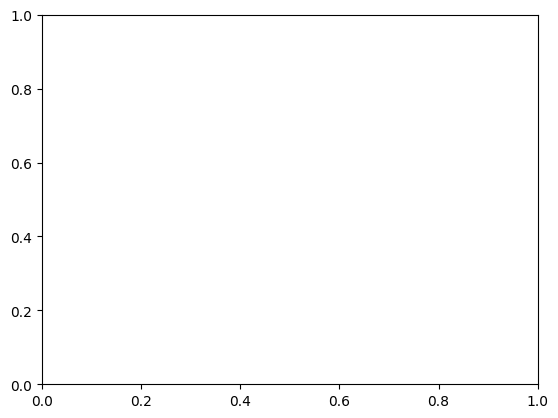

In [140]:
q_0 = np.array([np.pi*5/6, -np.pi*4/6, 0, 0, 0])
pos_x_1, pos_y_1 = sim_pos(q_0)
print('X: ' + f'{pos_x_1}')
print('Y: ' + f'{pos_y_1}')
plot(pos_y_1, pos_x_1)

### Velocity calculation

In [146]:
# Angular speed calculation
def ang_speed(q):
    dq = ca.SX.sym('dq', 5, 1)
    dtheta = abs_ang_rad(dq)
    return dtheta

dtheta_t = ang_speed(q)

In [ ]:
# Gravity centre velocity calculation
def dr(r):
    dr = sp.zeros(2,5)
    for i in range(5):
        dr[0, i] = sp.diff(r[0, i])
        dr[1, i] = sp.diff(r[1, i])
    return dr

dr_t = dr(r)

### Acceleration calculation

In [9]:
# Angular acceleration calculation
def ang_acc(q):
    theta = abs_ang_rad(q)          # Calculate absolute angles
    ddtheta = sp.zeros(5,1)         # Initialize matrix
    
    for i in range(5):
        ddtheta[i] = sp.diff(theta[i], t, 2)        # Second derivative of the absolute angles
    return ddtheta

ddtheta_t = ang_acc(q)

## Dynamics
### Kinetic energy

In [143]:
# Kinetic energy
def T(I, m, q, dr_t):
    dtheta = ang_speed(q)

    # Initialize matrices
    T_r = 0
    T_l = 0

    for i in range(5):
        T_r_new = (1/2) * I[i] * (dtheta[i] **2)
        T_r = ca.horzcat(T_r, T_r_new)
        T_l_new = (1/2) * m[i] * ((dr_t[0, i]**2) + dr_t[1, i]**2)
        T_r = ca.horzcat(T_r, T_l_new)
    T_t = np.sum(T_r) + np.sum(T_l)
    return T_t

### Potential energy

In [11]:
# Potential energy
def V(m, g, r):
    V = sp.zeros(5,1)
    for i in range(5):
        V[i] = g * m[i] * r[1, i]
    V_t = np.sum(V)
    return V_t

### Equations of motion

In [12]:
def Lagr(I, m, g, q, r, dr_t):
    V_t = V(m, g, r)            # Kinetic energy
    T_t = T(I, m, q, dr_t)      # Potential energy
    L = T_t - V_t               # Lagrangian

    # Initialize matrices that are going to be calculated afterwards in for loop
    dL_dq = sp.zeros(5,1)
    dL_ddq = sp.zeros(5,1)
    dL_ddq_dt = sp.zeros(5,1)
    e_motion = sp.zeros(5,1)
    
    # Each loop calculates one equation of motion
    for i in range(5):
        dL_dq[i] = sp.diff(L, q[i])                 # Derivative of Lagrangian respect q

        dL_ddq[i] = sp.diff(L, sp.diff(q[i]))       # Derivative of Lagrangian respect derivative of q
        dL_ddq_dt[i] = sp.diff(dL_ddq[i], t)        # Derivative of previous derivation respect the time

        e_motion[i] = dL_dq[i] - dL_ddq_dt[i]       # Rest both terms to obtain equations of motion
    
    return e_motion

eq_motion = Lagr(inertia, mass, g, q, r, dr_t)

### Definition of first and second derivatives of angles q

In [13]:
# Define first differentials of q
def dq_t(q):
    dq = sp.zeros(5,1)
    for i in range(5):
        dq[i] = sp.diff(q[i], t)
        dq = np.hstack(dq)
    return dq

# Define second differentials of q
def ddq_t(q):
    ddq = sp.zeros(5,1)
    for i in range(5):
        ddq[i] = sp.diff(q[i], t, 2)
    ddq = np.hstack(ddq)
    return ddq

dq = dq_t(q)
ddq = ddq_t(q)

### Rearrange equation of motion
Substituting second derivatives of q (accelerations) with mode shapes (e_i)

In [14]:
# Generate matrix of mode shapes
e1, e2, e3, e4, e5 = symbols('e1 e2 e3 e4 e5')
e = [e1, e2, e3, e4, e5]

# All acceleration terms must be substituted with mode shapes (e_i)
eq_motion_ei = eq_motion.subs(ddq[0], e[0]).subs(ddq[1], e[1]).subs(ddq[2], e[2]).subs(ddq[3], e[3]).subs(ddq[4], e[4])

Vector matrix: obtained by substituting mode shape terms with null value

In [15]:
# Vector matrix
def C(eq_motion_ei, e, dq, gr):
    # Substitute all acceleration terms with 0 so only vector matrix (C) is left
    C = eq_motion_ei.subs({e[0]: 0, e[1]: 0, e[2]: 0, e[3]: 0, e[4]: 0, g: gr})
    return C

C = C(eq_motion_ei, e, dq, 9.81)

# C_sus = C.subs({sp.diff(q1): 0, sp.diff(q2): 0, sp.diff(q3): 0, sp.diff(q4): 0, sp.diff(q5): 0})
# C_sus = C_sus.subs({q1: -np.pi/2, q2: np.pi/2, q3: np.pi/2, q4: -np.pi/2, q5:0})

# print(C_sus)


Mass matrix: obtained by substituting velocity terms and gravity with null value

In [16]:
# Mass matrix
def M(eq_motion_ei, e, dq):

    # Substituting velocity terms with zero, we obtain vector matrix = 0, so only mass matrix is left
    M_ei = eq_motion_ei.subs(dq[0], 0).subs(dq[1], 0).subs(dq[2], 0).subs(dq[3], 0).subs(dq[4], 0).subs(g, 0)
    M = sp.zeros(5,5)       # Initialize mass matrix

    # For each set of equations M*ei, the effect of each acceleration term is obtained
    for i in range(5):
        M[i, 0] = M_ei[i].subs(e1, 1).subs(e2, 0).subs(e3, 0).subs(e4, 0).subs(e5, 0)
        M[i, 1] = M_ei[i].subs(e1, 0).subs(e2, 1).subs(e3, 0).subs(e4, 0).subs(e5, 0)
        M[i, 2] = M_ei[i].subs(e1, 0).subs(e2, 0).subs(e3, 1).subs(e4, 0).subs(e5, 0)
        M[i, 3] = M_ei[i].subs(e1, 0).subs(e2, 0).subs(e3, 0).subs(e4, 1).subs(e5, 0)
        M[i, 4] = M_ei[i].subs(e1, 0).subs(e2, 0).subs(e3, 0).subs(e4, 0).subs(e5, 1)

    return M, M_ei

M, M_ei = M(eq_motion_ei, e, dq)

Active inputs: calculated by multiplying the input set with matrix B

In [17]:
# Array of controlled parameters u
def ControlledInputs(u):
    # Array B shows what inputs are active (from u1 to u4)
    B = np.array([[1, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0],
    ])

    B_u = np.vstack(np.dot(B, u))       # Set u5 to zero, meaning that head movement is not controlled
    return np.array(B_u)

B_u = ControlledInputs(u)

Final equation of motion: M*(ei) + C - B*u = 0

In [18]:
# Final set of equations of motion (M*ei + C - B*u = 0)
def e_motion_u(C, M_ei, u):
    e_motion_u = C + M_ei - ControlledInputs(u)
    return e_motion_u

In [19]:
# State equation
def state(q, dq):
    q_transposed = np.vstack(q)
    dq_transposed = np.vstack(dq)
    x = np.vstack([q_transposed, dq_transposed])
    return x

x = state(q, dq)

## Solver
### State space calculation

In [20]:
def d_state(q, dq, u, M, C):
    B_u = ControlledInputs(u)               # Calculate acting inputs and the inverse of the mass matrix
    M_inverse = np.linalg.inv(M)            # Inverse of matrix M
    ddq_u = np.dot(M_inverse, (B_u - C))    # Acceleration term given in the assigment notes (comes from solving for ei the equations of motion)
    
    dq_x = np.hstack(dq)                    # Generate array of speed
    ddq_x = np.hstack(ddq_u)                # Generate array of acceleration
    dx = np.hstack([dq_x, ddq_x])           # Derivative of the state

    return dx

### Openloop function
Substitute symbolical values with numerical values and calculate state-space model

In [21]:
# Openloop function to analyse each system each sample period
def openloop(x, t, u, M, C):
    q, dq = x[:5],x[5:]                 # First set desired state
    
    # Substitute mass matrix
    M = M.subs({q1: q[0], q2: q[1], q3: q[2], q4: q[3], q5: q[4]})
    M = np.array(M, dtype='float64')

    # Substitute vector matrix
    C = C.subs({sp.diff(q1): dq[0], sp.diff(q2): dq[1], sp.diff(q3): dq[2], sp.diff(q4): dq[3], sp.diff(q5): dq[4]})
    C = C.subs({q1: q[0], q2: q[1], q3: q[2], q4: q[3], q5: q[4]})
    C = np.array(C)

    # Derivative of the state
    dx = d_state(q, dq, u, M, C)
    dx = np.array(dx, dtype='float64')
    
    return dx

### Runge-Kutta 45

In [22]:
# Runge Kutta solver
def RK45_solver(time, x0, u, M, C, joint_order):
    start_time, end_time, h = time      # Define simulation time properties

    x = x0          # Initial state value
    q_x = x[:5]     # Initial angles
    dq_x = x[5:]    # Initial speed

    # Initial position of the body
    pos0_x, pos0_y = sim_pos(q_x, joint_order)
    body_pos_x = pos0_x
    body_pos_y = pos0_y

    count = 0       # Initialize loop counter

    # Initial time instance
    t = start_time
    t_acc = t

    while t <= end_time:
        
        # Simulate possible responses
        k1 = openloop(x, t, u, M, C)
        k2 = openloop(x+h*(k1/2), t+(h/2),u, M, C)
        k3 = openloop(x+h*(k2/2), t+(h/2),u, M, C)
        k4 = openloop(x+h*k3, t+h,u, M, C)

        # Calculate weighted response and save values
        x += h*(k1 + 2*k2 + 2*k3 + k4)/6
        q_x_1, dq_x_1 = x[:5], x[5:]

        # Calculate absolute position of each joint for time t
        x_sim, y_sim = sim_pos(q_x_1, joint_order)

        # If second foot touches ground, stop simulation
        if (y_sim[0, 6] < 0):
            t = end_time + 1        # End simulation
        else:
            # Add simulated state to data until simulation time
            q_x = np.vstack([q_x, q_x_1])       # Angles
            dq_x = np.vstack([dq_x, dq_x_1])    # Speeds
            t_acc = np.hstack([t_acc, t])       # Save time instance

            # Save body position
            body_pos_x = np.vstack([body_pos_x, x_sim])
            body_pos_y = np.vstack([body_pos_y, y_sim])

        # Print progress of the simulation
        print('\r%' + f"{int(100*(t)/end_time)}", end='', flush=True)
        
        # Add loop counter and time
        count = count + 1
        t = t + h

    body = [body_pos_x, body_pos_y]

    print('\r%' + f"{int(100)}", end='', flush=True)
    print('')
    
    if y_sim[0, 6] < 0:
        print('Second foot on the ground!!!')
        print('')

    # print('q')
    # print(q_x)
    # print('dq')
    # print(dq_x)
    # print('')
    # print('Position of the body joints')
    # print(body)
    # print('')
    # print('Time instances simulated')
    # print(t_acc)
    # print('')
    
    return q_x, dq_x, t_acc, body


## Animation function

In [23]:
# Animated pendulum
def animate_pendulum(t_ar, pos_x, pos_y, phi_sol, lengh, filename="GIF_try3.gif", slowdown=1, skip_frames=1):
    # Set up the figure, the axis, and the plot elements
    fig, (ax1, ax2) = plt.subplots(1, 2) # Ax1 human, Ax2 angles
    plt.subplots_adjust(wspace=0.5)  # Adjust the width spacing
    fig.suptitle('Biped walker gravity colapse')
    ax1.set_title('Biped walker movement')
    ax1.set_xlim(- 1.475, 3) # Full body aligned + 0.05
    ax1.set_ylim(- 1.475, 1.475) # Full body aligned + 0.05
    ax1.set_aspect(1)
    ax2.set_title('Joint Angles')
    y2min = np.min(phi_sol)
    y2max = np.max(phi_sol)   
    # y2min = -5*np.pi
    # y2max = 5*np.pi
    ax2.set_ylim(y2min-0.5, y2max+0.5) 
    ax2.set_xlim(0, 5) # t[0], t[-1]) 
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angle [rad]')
    # ax2.set_aspect((t[-1]-t[0])/(y2max-y2min))
    def radians_formatter(x, pos):
        return "{:.0f}".format(x/(np.pi))+"pi"
    #plt.gca().yaxis.set_major_formatter(FuncFormatter(radians_formatter))
    # display time
    time_text = ax1.text(0.04, 0.9, '', transform=ax1.transAxes)

    # create a rectangular Floor
    Floor_width = 10*1.475 # All the image
    Floor_height = 0.05
    rect = Rectangle([0 , -Floor_height],
                     Floor_width, Floor_height,
                     fill=True, color='red', ec='black')
    ax1.add_patch(rect)

    # Drawing the pendulum and lines
    Biped_walker, = ax1.plot([], [], lw=2, marker='o', markersize=6)
    Biped_walker_leg2, = ax1.plot([], [], lw=2, marker='o', markersize=6, color='red')
    phi1line, = ax2.plot([], [])
    phi2line, = ax2.plot([], [])
    phi3line, = ax2.plot([], [])
    phi4line, = ax2.plot([], [])
    phi5line, = ax2.plot([], [])

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0- Floor_width / 2.0,
                     -Floor_height))
        Biped_walker.set_data([], [])
        Biped_walker_leg2.set_data([], [])
        phi1line.set_data([], [])
        phi2line.set_data([], [])
        phi3line.set_data([], [])
        phi4line.set_data([], [])
        phi5line.set_data([], [])
        return time_text, rect, Biped_walker,Biped_walker_leg2, phi1line, phi2line, phi3line, phi4line, phi5line

    # animation function: update the objects
    def animate(i):
        new_i = i 
        time_text.set_text('time = {:2.2f}'.format(t_ar[i]))
        rect.set_xy((0 - Floor_width / 2.0, -Floor_height))
        x = pos_x[i]
        y = pos_y[i]
        # Set the walker points whell organized
        Biped_walker.set_data(pos_x[i], pos_y[i])
        Biped_walker_leg2.set_data(x[4:7], y[4:7])
        # Set each angle position
        phi1line.set_data(t_ar[:i], phi_sol[:i, 0])
        phi2line.set_data(t_ar[:i], phi_sol[:i, 1])
        phi3line.set_data(t_ar[:i], phi_sol[:i, 2])
        phi4line.set_data(t_ar[:i], phi_sol[:i, 3])
        phi5line.set_data(t_ar[:i], phi_sol[:i, 4])
        ax2.legend(['phi1', 'phi2', 'phi3', 'phi4', 'phi5'])
        return time_text, rect, Biped_walker,Biped_walker_leg2, phi1line, phi2line, phi3line, phi4line, phi5line

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t_ar),
                                   init_func=init,
                                   interval=t_ar[-1] / len(t_ar) * 1000 * slowdown,
                                   blit=False, repeat=False)
    plt.show(block=True)

    # save the animation if a filename is given
    if filename is not None:
        plt.rcParams['animation.ffmpeg_path'] = '/path/to/ffmpeg'
        anim.save(filename, fps=30)

## Heel Strike Impact Model

In [24]:
def change_of_leg(q_simulated, dq_simulated, M_matrix, C_matrix, joint):
    # Define leg position right before impact moment
    q1_plus, q2_plus, q3_plus, q4_plus, q5_plus = dynamicsymbols('q1_plus q2_plus q3_plus q4_plus q5_plus')
    qminus_symb = [q1_plus, q2_plus, q3_plus, q4_plus, q5_plus]
    r_minus = np.hstack([q_simulated[-1], dq_simulated[-1]])
    q_minus = r_minus[:5]
    dq_minus = r_minus[5:]
    M_minus_sym = M_matrix
    C_minus_sym = C_matrix
    joint_minus_sym = joint

    # Leg change matrix
    leg_change = np.array([[0, 1, 0, 0, 0],
                        [1, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 1]])

    # Calculate q for after impact
    q_plus_t = np.dot(leg_change, q)
    q_plus_sym = np.dot(leg_change, qminus_symb)
    q_plus = np.dot(leg_change, q_minus)
    #print('q minus:' + f'{q_minus}')
    #print('q plus:' + f'{q_plus}')

    # Change symbolic mass matrix
    M_plus_sym = M_minus_sym.subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
    M_plus_sym = M_plus_sym.subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    #print('M-: ' + f'{M_minus_sym}')
    #print('M+: ' + f'{M_plus_sym}')

    # Change symbolic vector matrix
    C_plus_sym = C_minus_sym.subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
    C_plus_sym = C_plus_sym.subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    #print('C-: ' + f'{C_minus_sym}')
    #print('C+: ' + f'{C_plus_sym}')

    # Change joint_order matrix
    joint_plus_sym = sp.zeros(2, 7)
    for i in range(2):
        for j in range(6):
            joint_plus_sym[i, j+1] = joint_minus_sym[i, j+1].subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
            joint_plus_sym[i, j+1] = joint_plus_sym[i, j+1].subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    # print('Joint -: ' + f'{joint_minus_sym}')
    # print('Joint +: ' + f'{joint_plus_sym}')

    # Calculate mass matrix before and after impact
    M_minus = M_minus_sym.subs({q1: q_minus[0], q2: q_minus[1], q3: q_minus[2], q4: q_minus[3], q5: q_minus[4]})
    M_plus = M_minus_sym.subs({q1: q_plus[0], q2: q_plus[1], q3: q_plus[2], q4: q_plus[3], q5: q_plus[4]})
    M_plus = np.array(M_plus, dtype='float64')

    # Calculate speed for after impact: M+ * dq+ = M- * dq- --> dq+ = ((M+)^-1) * (M- * dq-)
    momentum_minus = np.dot(M_minus, dq_minus)
    M_plus_inv = np.linalg.inv(M_plus)
    dq_plus = np.dot(M_plus_inv, momentum_minus)

    #print('dq minus:' + f'{dq_minus}')
    #print('dq plus:' + f'{dq_plus}')

    return q_plus, dq_plus, M_plus_sym, C_plus_sym, joint_plus_sym

## Working Simulation with heel strike impact

In [25]:
######### NO INPUT SIMULATION WITH HEEL STRIKE IMPACT #########

step_number = 2                             # Define number of desired steps to be simulated

# Initial conditions for first step
q0 = q_0
dq0 = np.array([0, 0, 0, 0, 0])
x0 = np.hstack([q0, dq0])
x = x0

############################ ERROR ############################
##### Value for x0 is changing when is called by function #####
##### When x0 is defined above, values are as indicated   #####
##### When called by the function, x0 changes slightly    #####

solving_time = [0, 1, 0.02]                 # Time interval = [Starting time, Ending Time, Step Size]
u = ControlledInputs([0,0,0,0,0])           # Inputs
i = 0                                       # Initialize step counter

while i < step_number:
    # Call solver
    q_sim, dq_sim, t_array, bodypos = RK45_solver(solving_time, x, u, M, C, joint_order)

    # When solver has finished, it means free foot has touched the ground, so matrices must be changed
    qplus, dqplus, Mplus, Cplus, jointplus = change_of_leg(q_sim, dq_sim, M, C, joint_order)

    # Next state
    x = np.hstack([qplus, dqplus])

    # New matrices with coordinate change
    M = Mplus
    C = Cplus

    # Stack values if it is not the first step (i < 0)
    if i > 0:
        q_sim_acc = np.vstack([q_sim_acc, q_sim])
        dq_sim_acc = np.vstack([dq_sim_acc, dq_sim])
        t_array_acc = np.hstack([t_array_acc, (t_array + t_array_acc[-1])])
        last_pos_x = body_x_acc[-1]
        body_x_acc = np.vstack([body_x_acc, bodypos[0] + last_pos_x[-1]])
        body_y_acc = np.vstack([body_y_acc, bodypos[1]])
    else:
        q_sim_acc = q_sim
        dq_sim_acc = dq_sim
        t_array_acc = t_array
        body_x_acc = bodypos[0]
        body_y_acc = bodypos[1]

    # Add step
    i = i + 1

last_x = body_x_acc[-1]
body_x_corrected = last_x - last_x[-1]      # Correction of last position of the body

# Save values in external files
np.save('q.npy', q_sim_acc)
np.save('dq.npy', dq_sim_acc)
np.save('time.npy', t_array_acc)
np.save('body_position_x.npy', body_x_acc)
np.save('body_position_y.npy', body_y_acc)

%100
Segundo pie en suelo!!!

%100
Segundo pie en suelo!!!



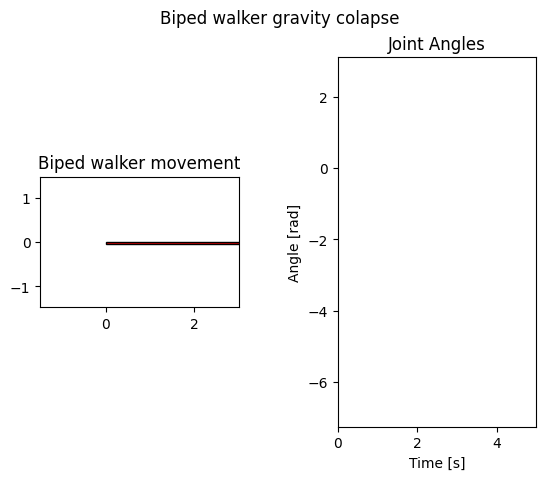

MovieWriter ffmpeg unavailable; using Pillow instead.


In [26]:
# Animate resulting body
animate_pendulum(t_array_acc, body_x_acc, body_y_acc, q_sim_acc, length)

## Constraint value problem

In [29]:
###### DATA #######
L = 0.36                    # Step size = 0.8(length of leg) * 0.45(average human step relation factor ) = 0.36
T = 0.576                   # Average human step duration = 0.576
N = 50                      # Number of control intervals
dt = T/N                    # Length of a control interval
ang_sp = 0.5                # Starting speed of free leg

# Inverse kinematics equations for start and final angles
angle_1 = np.pi + math.asin((L / 2) / 0.8)
angle_2 = np.pi - math.asin((L / 2) / 0.8)

###### OPTIMIZATION PROBLEM ######
opti = casadi.Opti()        #Optimization problem

# Initial state
q_ini = [angle_1, angle_2, 0, 0, 0]       # Initial angles
dq_ini = [0 ,0, 0, ang_sp, 0]             # Initial speed
x_ini_des = np.hstack([q_ini, dq_ini])    # Initial state
pos_x_ini, pos_y_ini = sim_pos(q_ini, joint_order)
body_ini = np.vstack([pos_x_ini, pos_y_ini])
#print('Initial body state position: ' + f'{body_ini}')
#plot(pos_y_ini, pos_x_ini)

# Final state
q_end = [angle_2, angle_1, 0, 0, 0]       # Final angles
dq_end = [0 ,0, 0, -ang_sp, 0]            # Final speed
x_end_des = np.hstack([q_end, dq_end])    # Final state
pos_x_end, pos_y_end = sim_pos(q_end, joint_order)
body_end = np.vstack([pos_x_end, pos_y_end])
#print('Final body state position: ' + f'{body_end}')
#plot(pos_y_end, pos_x_end)


###### Decision variables #######
X = opti.variable(10, N+1)    # State
pos = X[:5, :]                # Relative angles q
speed = X[5:, :]              # Relative velocities dq
U = opti.variable(5, N)       # Control trajectory

# Cost rate
cost = (U[0]**2 + U[1]**2 + U[2]**2 + U[3]**2 + U[4]**2) / 2

# Set minimization objective
opti.minimize(cost)

# Loop over control intervals with Runge-Kutta 4 solver
for k in range(N):
   # Simulate possible responses
   k1 = openloop(X, T, U, M, C)
   k2 = openloop(X + dt*(k1/2), T+(dt/2), U, M, C)
   k3 = openloop(X + dt*(k2/2), T+(dt/2), U, M, C)
   k4 = openloop(X + dt*k3, T+dt, U, M, C)

   # Calculate weighted response and save values
   x_next = X[:, k] + dt*(k1 + 2*k2 + 2*k3 + k4)/6
   q_x_1, dq_x_1 = X[:5, k], X[5:, k]

   opti.subject_to(X [:,k+1] == x_next)     # Close the gaps

# Boundary conditions and constraints
opti.subject_to((X[:, 0] == x_ini_des))     # BC: Initial state
opti.subject_to((X[:, N] == x_end_des))     # BC: Final state
opti.subject_to(U[:, :] > 0)                   # Input constraint: positive value always

# Inital guess for the solver
opti.set_initial(X[:], 0)
opti.set_initial(U[:], 0)

###### Solve the NLP using IPOPT #######
opti.solver('ipopt')                        # Set numerical backend
sol = opti.solve()                          # Actual solve

RuntimeError: .../casadi/core/mx_node.cpp:386: 'to_double' not defined for class N6casadi16GetNonzerosSliceE